<a href="https://colab.research.google.com/github/hyogyeong/ESAA/blob/main/%EA%B0%80%EB%A7%B9%EC%A0%90_X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#가맹점 변수 제거한 데이터 셋 머신러닝

#데이터 불러오기

In [ ]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data_final = pd.read_csv('Final2.csv', encoding = 'cp949')
df = data_final.copy()

print('데이터 세트의 Shape:', df.shape)
print('\n전체 feature 들의 type \n',df.dtypes.value_counts())
isnull_series = df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (3511, 9)

전체 feature 들의 type 
 int64     8
object    1
dtype: int64

Null 컬럼과 그 건수:
  Series([], dtype: int64)


In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df

,month,성별코드,연령대코드,종류,시군구명,인구수,가맹점수,결제금액
0,4,0,1,0,고양시,1066351,19876,8400
1,4,0,1,0,광명시,316552,5456,51700
2,4,0,1,0,광주시,372654,5872,40700
3,4,0,1,0,군포시,275852,5915,2173450
4,4,0,1,0,남양주,701830,11331,610250
...,...,...,...,...,...,...,...,...
3506,9,1,8,0,하남시,272455,5025,1625640
3507,9,1,8,0,화성시,815396,15145,504450
3508,9,1,9,0,고양시,1066351,19876,217620
3509,9,1,9,0,양평군,116874,3192,670583


# 로그 변환

In [ ]:
# SalePrice 로그 변환
original_결제금액 = df['결제금액']
df['결제금액'] = np.log1p(df['결제금액'])

In [ ]:
print('get_dummies() 수행 전 데이터 Shape:', df.shape)
df_ohe = pd.get_dummies(df)
print('get_dummies() 수행 후 데이터 Shape:', df_ohe.shape)

null_column_count = df.isnull().sum()[df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', df.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (3511, 8)
get_dummies() 수행 후 데이터 Shape: (3511, 35)
## Null 피처의 Type :
 Series([], dtype: object)


#선형회귀 모델 평가 (RMSE)

In [ ]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

# 선형회귀 학습(릿지, 라쏘, 회귀)

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = df_ohe['결제금액']
X_features = df_ohe.drop('결제금액',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [ ]:
# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 2.124
Ridge 로그 변환된 RMSE: 2.124
Lasso 로그 변환된 RMSE: 2.225


[2.124290878898321, 2.1237252818823955, 2.2247636136541016]

# feature별 회귀 계수를 시각화 (상위10개, 하위 10개)

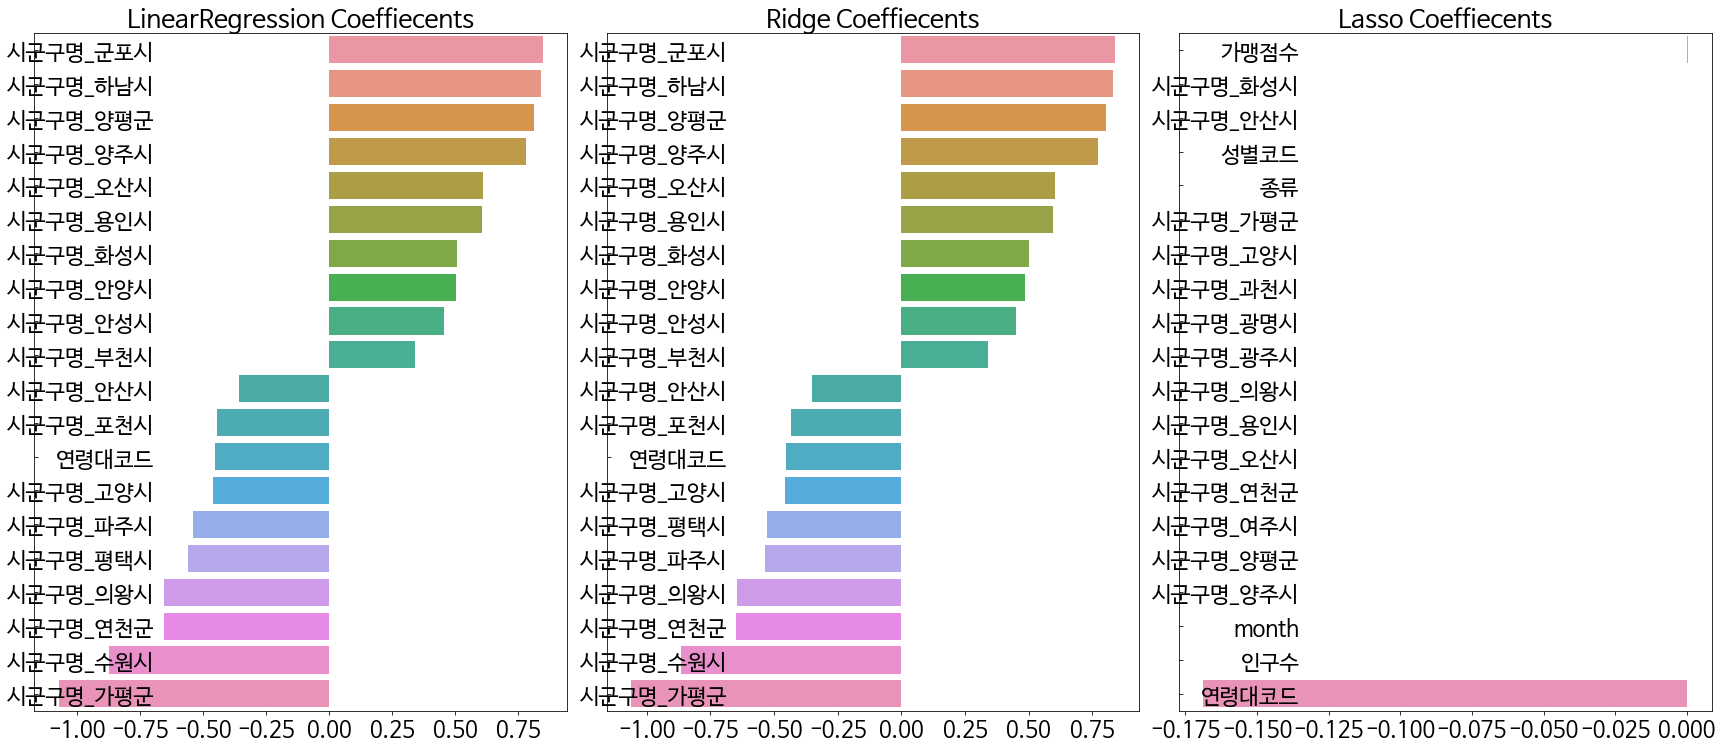

In [ ]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

# 데이터 분할이 문제일수도 있으니 교차검증(CV)를 통해 RMSE 측정

In [ ]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [2.434 2.145 2.086 2.098 2.274]
LinearRegression CV 평균 RMSE 값: 2.208

Ridge CV RMSE 값 리스트: [2.434 2.144 2.086 2.098 2.273]
Ridge CV 평균 RMSE 값: 2.207

Lasso CV RMSE 값 리스트: [2.519 2.251 2.224 2.23  2.321]
Lasso CV 평균 RMSE 값: 2.309


# 파라미터 최적화(릿지, 라쏘)후 RMSE 측정

In [ ]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3 ] }
best_rige = print_best_params(ridge_reg, ridge_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 2.2107, 최적 alpha:{'alpha': 2.3}


In [ ]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

lasso_params = { 'alpha':[0.001, 0.005, 0.008] }
best_lasso = print_best_params(lasso_reg, lasso_params)

Lasso 5 CV 시 최적 평균 RMSE 값: 2.2089, 최적 alpha:{'alpha': 0.005}


# 최적화한 하이퍼 파라미터로 다시 모델 학습 후 모델별 회귀 계수 다시 시각화

LinearRegression 로그 변환된 RMSE: 2.124
Ridge 로그 변환된 RMSE: 2.123
Lasso 로그 변환된 RMSE: 2.12


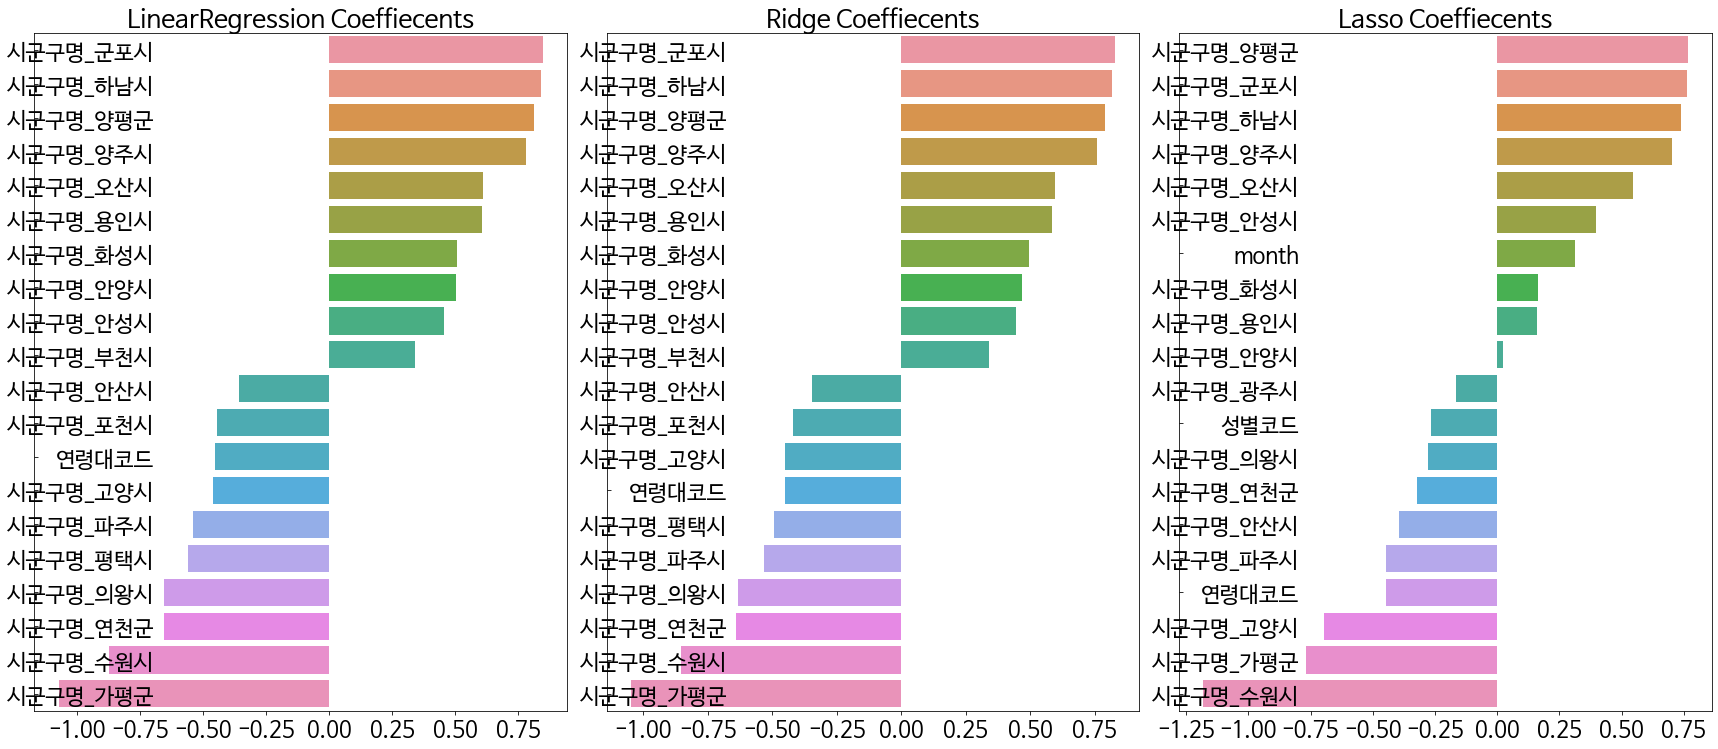

In [ ]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=2.3)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.005)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

# 왜곡된 feature가 존재할 경우 회귀 예측 성능을 저하시키므로 왜곡된 정도를 확인하자
### 일반적으로 skew() 함수의 반환값이 1이상일 경우 왜곡 정도가 높다고 판단하지만 상황에 따라 편차가 존재한다. 여기서는 1 이상의 왜곡 정도를 보이는 feature에 로그 변환을 적용하도록 하겠다. skew() 함수를 사용할 때 주의할 점으로는 one-hot 인코딩된 카테고리 숫자형 feature는 제외시켜야한다.

In [ ]:
from scipy.stats import skew

# object가 아닌 숫자형 피쳐의 컬럼 index 객체 추출.
features_index = df.dtypes[df.dtypes != 'object'].index
# df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 
skew_features = df[features_index].apply(lambda x : skew(x))
# skew 정도가 1 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 1]
df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
df_ohe = pd.get_dummies(df)
y_target = df_ohe['결제금액']
X_features = df_ohe.drop('결제금액',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [ ]:
skew_features_top

Series([], dtype: float64)

In [ ]:
# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 2.2083, 최적 alpha:{'alpha': 20}
Lasso 5 CV 시 최적 평균 RMSE 값: 2.2089, 최적 alpha:{'alpha': 0.005}


# feature를 로그변환 후 다시 모델 학습 후 회귀 계수 시각화

LinearRegression 로그 변환된 RMSE: 2.124
Ridge 로그 변환된 RMSE: 2.118
Lasso 로그 변환된 RMSE: 2.12


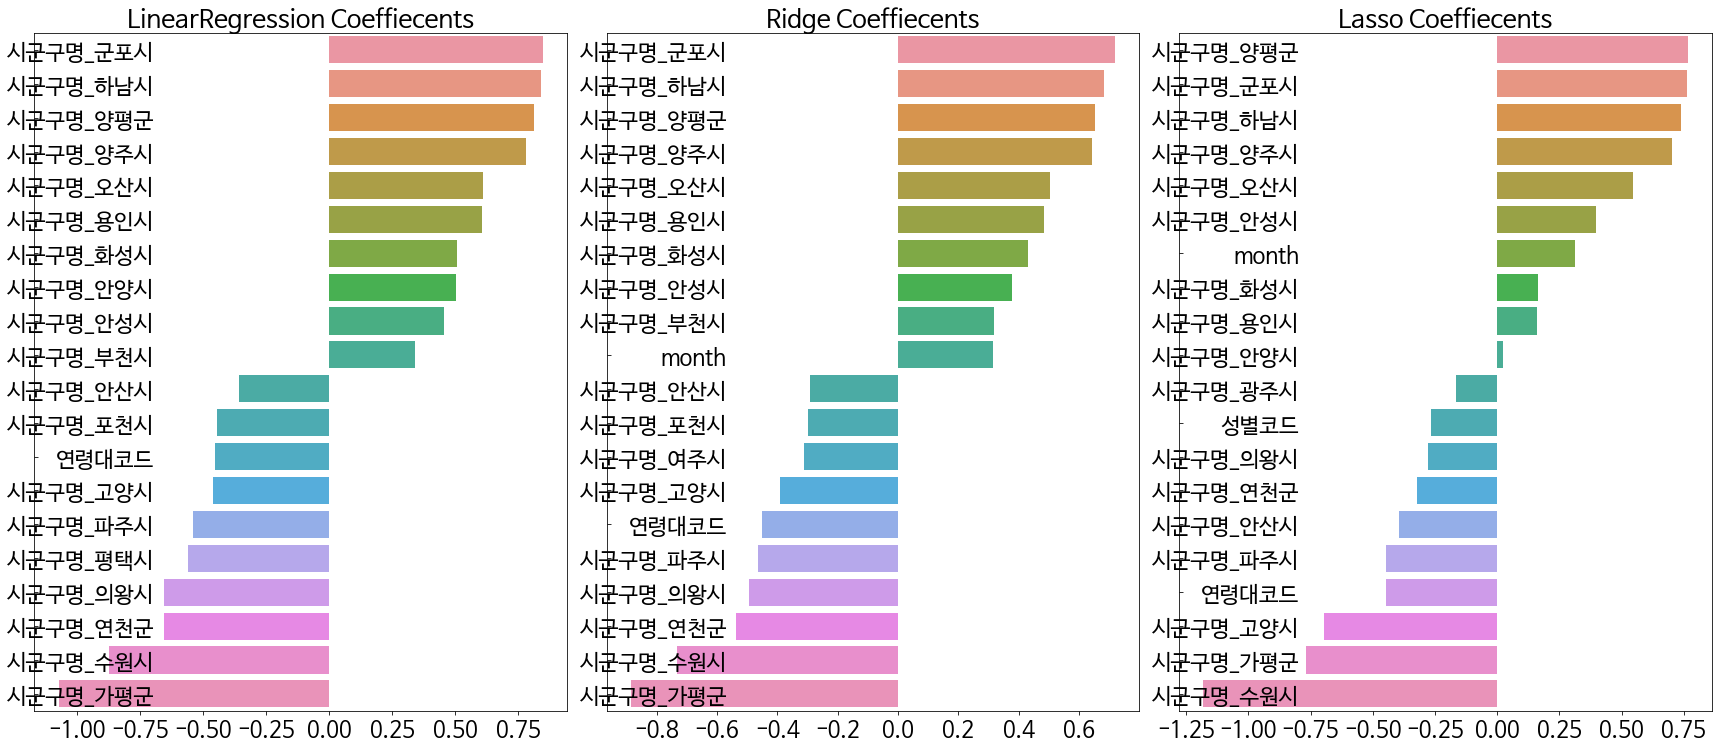

In [ ]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.005)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

# 회귀 트리를 이용한 회귀 모델 만들기 (XGBoost, LightGBM)

In [ ]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=2)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [ ]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(tree_method = 'exact', objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.5)


In [ ]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 1.5026, 최적 alpha:{'n_estimators': 1000}


In [ ]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 1.768, 최적 alpha:{'n_estimators': 1000}


# 피처 중요도 시각화

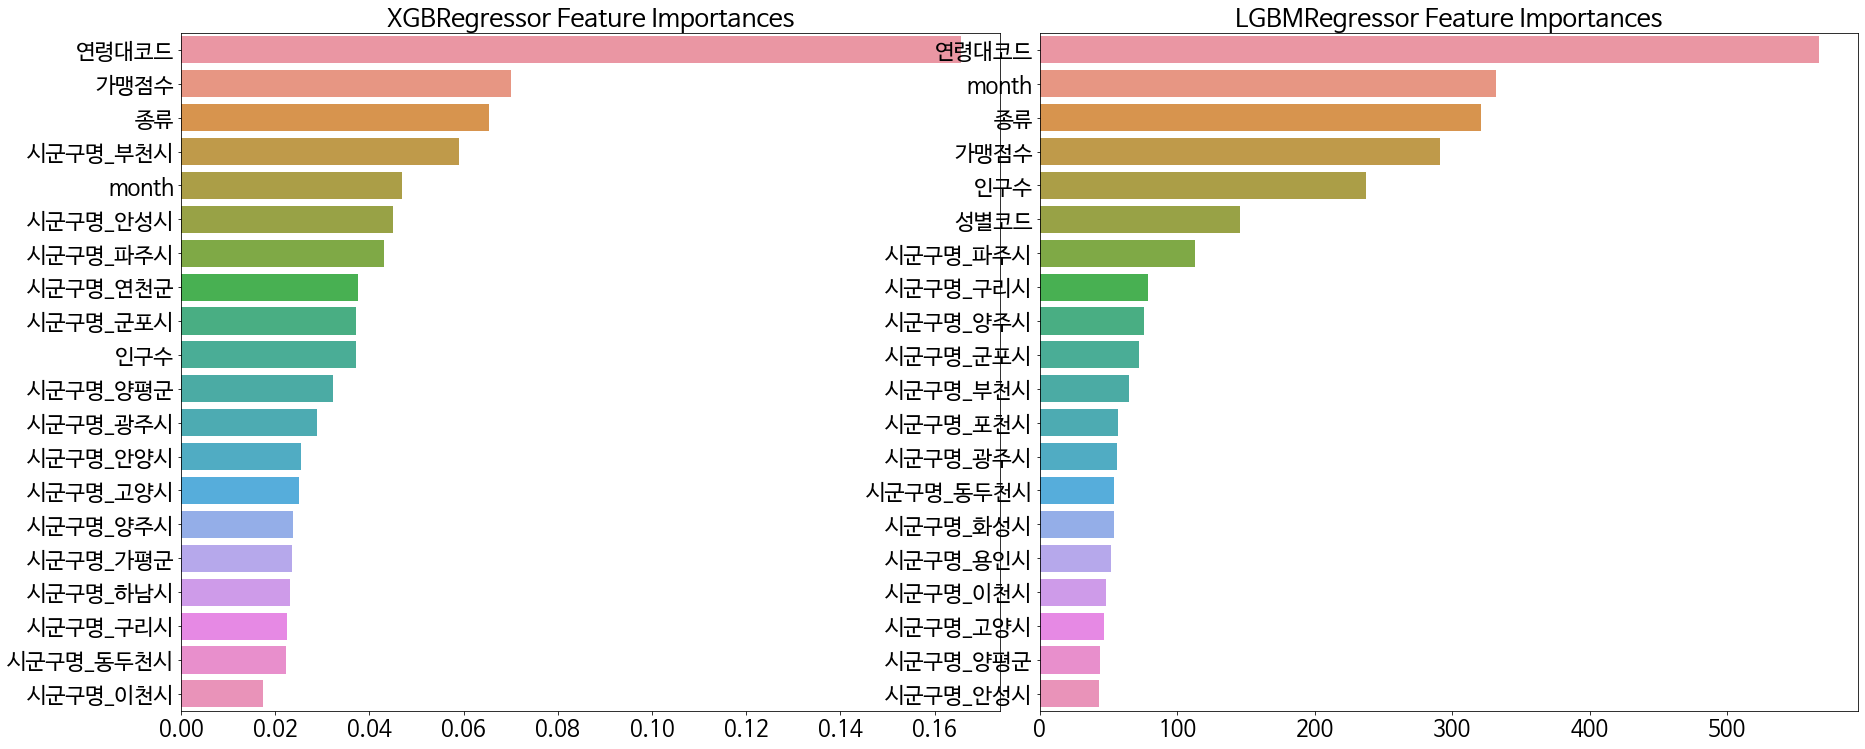

In [ ]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

# 회귀 모델의 예측 결과 혼합을 통한 최종 예측
### 개별 회귀 모델의 예측 결과값을 혼합해 이를 기반으로 최종 회귀 값을 예측해보겠다. 기본적으로 예측 결과 혼합은 매우 간단하다. 두 모델의 예측값이 주어지면 두 모델의 예측값이 차지할 비율을 나눈 다음 합하여 최종 회귀 값으로 예측하는 것이다. 우선 릿지와 라쏘 모델을 서로 혼합해보겠다.

In [ ]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 2.1212924391757073
Ridge 모델의 RMSE: 2.1208237493147046
Lasso 모델의 RMSE: 2.121653046529354


In [ ]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
  
get_rmse_pred(preds)

[15:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 모델의 RMSE: 1.0624284900364531
XGBM 모델의 RMSE: 0.9314290082206192
LGBM 모델의 RMSE: 1.2526241150287616


#스태킹 앙상블 모델을 통한 회귀 예측
스태킹 모델을 회귀에 적용할 수 있다. 스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습 dataset과 테스트 dataset을 만드는 것이다. 적용할 개별 모델은 릿지, 라쏘, XGBoost, LightGBM으로 4개이고, 메타 모델은 라쏘 모델을 사용하여 학습하고 예측을 수행해보겠다.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
       
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
   
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('메타 모델에 라쏘 모델을 적용한 스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

# 최종 메타 모델은 릿지 모델을 적용. 
meta_model_ridge = Ridge(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_ridge.fit(Stack_final_X_train, y_train)
final = meta_model_ridge.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('메타 모델에 릿지 모델을 적용한 스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

# 최종 메타 모델은 XGBRegressor 모델을 적용. 
meta_model_ridge = Ridge(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_ridge.fit(Stack_final_X_train, y_train)
final = meta_model_ridge.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('메타 모델에 XGBRegressor 모델을 적용한 스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

# 최종 메타 모델은 LGBMRegresso 모델을 적용. 
meta_model_LGBMRegressor = LGBMRegressor(n_estimators=1000)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_LGBMRegressor.fit(Stack_final_X_train, y_train)
final = meta_model_LGBMRegressor.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('메타 모델에 LGBMRegresso 모델을 적용한 스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

[15:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
메타 모델에 라쏘 모델을 적용한 스태킹 회귀 모델의 최종 RMSE 값은: 0.8872697961779897
메타 모델에 릿지 모델을 적용한 스태킹 회귀 모델의 최종 RMSE 값은: 0.8868545263597911
메타 모델에 XGBRegressor 모델을 적용한 스태킹 회귀 모델의 최종 RMSE 값은: 0.8868545263597911
메타 모델에 LGBMRegresso 모델을 적용한 스태킹 회귀 모델의 최종 RMSE 값은: 0.9989834641026393
